In [139]:
import geopandas as gpd
import rasterio
from shapely.geometry import Point
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj

# 读取矢量数据
# 读取矢量数据

river_gdf = gpd.read_file('../data/最新赣江河流.shp')
candidate_points_gdf = gpd.read_file('../data/含有保留点的总候选点.shp')

# 读取栅格数据
human_activity_raster_path = '../data/河岸五公里的人类活动强度栅格数据.tif'


human_activity_raster = rasterio.open(human_activity_raster_path)

# 打印数据的坐标系
print("河流数据的坐标系:", river_gdf.crs)
print("栅格数据的坐标系:", human_activity_raster.crs)
print("候选点数据的坐标系:", candidate_points_gdf.crs)

河流数据的坐标系: EPSG:4326
栅格数据的坐标系: EPSG:4326
候选点数据的坐标系: EPSG:4326


In [140]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
import numpy as np
import pyproj
from rasterio.features import geometry_mask
class Individual:
    def __init__(self, chromosome):
        """
        初始化个体。
        
        参数：
        chromosome - 一个表示候选监测点选择状态的二进制数组。
        """
        self.chromosome = chromosome
        self.fitness = 0


In [141]:
import numpy as np
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union

class Population:
    def __init__(self, pop_size, num_candidates, num_selected_points, fixed_indices):
            """
            初始化种群。
            
            参数：
            pop_size - 种群大小，即种群中个体的数量。
            num_candidates - 候选监测点的数量，即个体染色体的长度。
            num_selected_points - 每个个体中选取的监测点数量。
            # fixed_indices - 一个列表，包含需要固定的监测点的索引。
            """
            self.pop_size = pop_size
            self.num_candidates = num_candidates
            self.num_selected_points = num_selected_points
            self.fixed_indices = fixed_indices
            self.individuals = [self.create_individual() for _ in range(pop_size)]

    def create_individual(self):
            """
            创建一个随机个体，确保个体中有指定数量的监测点被选中。
            
            返回：
            Individual - 新创建的个体。
            """
            # 初始化一个全零的染色体数组，长度为候选监测点的数量
            chromosome = np.zeros(self.num_candidates, dtype=int)
            # print(f"初始化的染色体: {chromosome}")
            
            # 注释掉固定的保留点设置为1
            chromosome[self.fixed_indices] = 1
            # print(f"设置固定保留点后的染色体 (固定索引: {self.fixed_indices}): {chromosome}")

            # 计算剩余需要选择的点的数量
            remaining_points = self.num_selected_points - len(self.fixed_indices)
            # print(f"剩余需要选择的点数量: {remaining_points}")
            # 检查剩余点数是否为负值，抛出异常
            if remaining_points < 0:
                raise ValueError("选择的点数量不能少于固定点的数量。")

            if remaining_points > 0:
                # 随机选择其余的点，排除已经固定的点
                available_indices = np.setdiff1d(np.arange(self.num_candidates), self.fixed_indices)
                # print(f"可供选择的索引: {available_indices}")

                selected_indices = np.random.choice(available_indices, remaining_points, replace=False)
                # print(f"随机选择的索引: {selected_indices}")

                chromosome[selected_indices] = 1
                # print(f"随机选择后的染色体: {chromosome}")
            
            # 返回一个新的 Individual 对象，使用生成的染色体数组初始化
            # print(f"最终染色体: {chromosome}")
            return Individual(chromosome)

    def evaluate_population(self, candidate_points_gdf, buffer_gdf, human_activity_raster):
        """
        评估种群中所有个体的适应度。
        
        参数：
        candidate_points_gdf - 包含候选点的 GeoDataFrame。
        buffer_gdf - 包含缓冲区几何的 GeoDataFrame。
        human_activity_raster - 人类活动强度的栅格数据。
        """
        for individual in self.individuals:
            # 获取该个体中选定的候选点索引（即该个体染色体中为1的基因对应的索引）
            selected_fids = [fid for fid, gene in zip(candidate_points_gdf['point_id'], individual.chromosome) if gene == 1]

            if len(selected_fids) == 0:
                # 如果没有选择任何点，则适应度为0
                individual.fitness = 0
                continue

            # 计算该个体的合并缓冲区的人类活动强度
            combined_intensity = self.calculate_intensity_for_merged_buffers(selected_fids, buffer_gdf, human_activity_raster)

            # 将合并强度作为该个体的适应度
            individual.fitness = combined_intensity
            
    def calculate_intensity_for_merged_buffers(self, selected_fids, buffer_gdf, raster):
            """
            计算选定候选点的合并缓冲区的人类活动强度。
            
            参数：
            selected_fids - 选定的候选点 FID 列表。
            buffer_gdf - 包含缓冲区几何的 GeoDataFrame。
            raster - 人类活动强度的栅格数据。
            
            返回：
            total_intensity - 合并缓冲区内的人类活动强度总值。
            """
            def calculate_intensity_for_buffer(buffer_geom, raster):
                """
                计算给定几何形状内的覆盖人类活动强度栅格值。
                
                参数：
                buffer_geom - 几何形状，用于计算的缓冲区或重叠区域。
                raster - 人类活动强度的栅格数据。
                
                返回：
                total_value - 几何形状内的总强度值。
                """
                # 1. 获取栅格的仿射变换信息（transform）和 NoData 值
                transform = raster.transform
                nodata_value = raster.nodata

                # 2. 创建掩膜，遮罩掉缓冲区外的像素，仅保留缓冲区内的像素
                try:
                    buffered_raster = geometry_mask([buffer_geom], transform=transform, invert=True, out_shape=(raster.height, raster.width))
                except ValueError as e:
                    print(f"几何对象无效或为空: {e}")
                    return 0

                # 3. 读取栅格数据（假设是单波段，读取第一波段数据）
                raster_data = raster.read(1)

                # 4. 应用掩膜，将缓冲区外的像素设置为 NaN，仅保留缓冲区内的像素
                masked_data = np.where(buffered_raster, raster_data, np.nan)

                # 5. 过滤掉 NoData 像素
                valid_raster_values = masked_data[masked_data != nodata_value]

                # 6. 如果没有有效的栅格值（即缓冲区内全为 NoData），返回 0
                if valid_raster_values.size == 0:
                    return 0

                # 7. 计算缓冲区内的总强度值
                total_value = np.nansum(valid_raster_values)

                return total_value

            # 1. 获取所有选定候选点的缓冲区几何
            selected_geometries = buffer_gdf.loc[buffer_gdf['所属点'].isin(selected_fids), 'geometry'].tolist()

            # 检查是否有有效的几何对象
            if len(selected_geometries) == 0:
                print("未找到有效的几何对象。")
                return 0

            # 2. 合并这些几何对象为一个单一几何对象
            try:
                merged_geometry = unary_union(selected_geometries)

                # 检查合并后的几何对象是否为空或无效
                if merged_geometry.is_empty:
                    print("合并后的几何对象为空。")
                    return 0

            except Exception as e:
                print(f"几何合并失败: {e}")
                return 0

            # 3. 使用合并后的几何对象计算人类活动强度
            total_intensity = calculate_intensity_for_buffer(merged_geometry, raster)
            
            return total_intensity



    def get_fittest_individual(self):
        """
        获取种群中适应度最高的个体。
        
        返回：
        Individual - 适应度最高的个体。
        """
        return max(self.individuals, key=lambda ind: ind.fitness)



In [142]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt


class GeneticAlgorithm:
    def __init__(self, pop_size, num_candidates, crossover_rate, mutation_rate, max_generations, num_selected_points, fixed_indices,k):
        """
        初始化遗传算法参数。
        
        参数：
        pop_size - 种群大小，即种群中个体的数量。
        num_candidates - 候选监测点的数量，即个体染色体的长度。
        crossover_rate - 交叉概率。
        mutation_rate - 变异概率。
        max_generations - 最大迭代次数。
        num_selected_points - 每个个体中选取的监测点数量。
        fixed_indices - 固定的监测点索引（可选，默认为None）。
        """
        self.pop_size = pop_size
        self.num_candidates = num_candidates
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.max_generations = max_generations
        self.num_selected_points = num_selected_points
        self.fixed_indices = fixed_indices  
        self.k = k

    def initialize_population(self):
        """
        初始化种群。
        
        返回：
        Population - 新创建的种群。
        """
        return Population(self.pop_size, self.num_candidates, self.num_selected_points,self.fixed_indices)

    def select_parents(self, population):
        """
        选择父代个体。使用K锦标赛选择方法。
        
        参数：
        population - 当前种群。
        
        返回：
        选择的两个父代个体。
        """
        tournament_size = self.k  # K值，可以根据需要调整
        
        def tournament_selection():
            # 从种群中随机选择K个个体
            tournament = np.random.choice(population.individuals, tournament_size, replace=False)
            # 选择适应度最高的个体
            best_individual = max(tournament, key=lambda ind: ind.fitness)
            return best_individual
        
        parent1 = tournament_selection()
        parent2 = tournament_selection()
        return parent1, parent2
    
    def crossover(self, parent1, parent2):
        """
        执行交叉操作生成子代个体。使用多点交叉方法。

        参数：
        parent1 - 第一个父代个体。
        parent2 - 第二个父代个体。

        返回：
        两个子代个体。
        """
        if np.random.rand() < self.crossover_rate:
            num_points = np.random.randint(2, min(5, self.num_candidates // 2))
            crossover_points = np.sort(np.random.choice(self.num_candidates, num_points, replace=False))
            child1_chromosome = parent1.chromosome.copy()
            child2_chromosome = parent2.chromosome.copy()

            for i in range(num_points):
                if i % 2 == 1:
                    start = crossover_points[i-1]
                    end = crossover_points[i]
                    # 交叉操作
                    child1_chromosome[start:end] = parent2.chromosome[start:end]
                    child2_chromosome[start:end] = parent1.chromosome[start:end]

            # 注释掉固定保留点不受影响的代码
            child1_chromosome[self.fixed_indices] = 1
            child2_chromosome[self.fixed_indices] = 1

            # 确保子代染色体中选择点数量正确
            child1_chromosome = self.correct_chromosome(child1_chromosome)
            child2_chromosome = self.correct_chromosome(child2_chromosome)

            return Individual(child1_chromosome), Individual(child2_chromosome)
        else:
            return parent1, parent2

    def mutate(self, individual):
        """
        执行变异操作。使用子集反转方法。
        
        参数：
        individual - 需要变异的个体。
        """
        if np.random.rand() < self.mutation_rate:
            # 获取可变异的索引，注释掉固定保留点相关代码
            mutable_indices = np.setdiff1d(np.arange(self.num_candidates), self.fixed_indices)
            
            # 如果可变异的位置数大于1，进行反转操作
            if len(mutable_indices) > 1:
                # 随机选择一个子集的起始位置和长度
                start_index = np.random.choice(mutable_indices)
                end_index = start_index + np.random.randint(1, len(mutable_indices) // 2 + 1)

                # 确保 end_index 不超过染色体的边界
                end_index = min(end_index, len(mutable_indices))

                # 提取要反转的子集
                subset_to_reverse = mutable_indices[start_index:end_index]

                # 反转子集
                reversed_subset = subset_to_reverse[::-1]

                # 更新染色体：将选定子集的基因反转
                individual.chromosome[subset_to_reverse] = individual.chromosome[reversed_subset]

            # 确保染色体中选择点数量正确
            individual.chromosome = self.correct_chromosome(individual.chromosome)

    
    def correct_chromosome(self, chromosome):
        """
        校正染色体中选中点的数量，确保数量正确且保留点不被移除。

        参数：
        chromosome - 需要校正的染色体。

        返回：
        校正后的染色体。
        """
        # 计算当前染色体中选中的点数量
        num_selected = np.sum(chromosome)

        # 如果选中点数量多于指定数量，随机移除一些非保留点
        if num_selected > self.num_selected_points:
            # 注释掉移除非保留点的代码
            excess_indices = np.where((chromosome == 1) & (~np.isin(np.arange(self.num_candidates), self.fixed_indices)))[0]
            indices_to_remove = np.random.choice(excess_indices, num_selected - self.num_selected_points, replace=False)
            chromosome[indices_to_remove] = 0

        # 如果选中点数量少于指定数量，随机添加一些非保留点
        elif num_selected < self.num_selected_points:
            # 注释掉添加非保留点的代码
            available_indices = np.where((chromosome == 0) & (~np.isin(np.arange(self.num_candidates), self.fixed_indices)))[0]
            indices_to_add = np.random.choice(available_indices, self.num_selected_points - num_selected, replace=False)
            chromosome[indices_to_add] = 1

        # 注释掉保留点始终为1的代码
        chromosome[self.fixed_indices] = 1

        return chromosome


    def evolve(self, candidate_points_gdf, buffer_gdf,human_activity_raster):
        """
        运行遗传算法，进化种群直至满足停止条件。
        
        参数：
        candidate_points - 候选监测点列表。
        raster_data - 栅格数据，用于计算人类活动强度。
        
        返回：
        Population - 进化后的种群。
        """
        # 初始化种群
        population = self.initialize_population()

        # 记录每代中最适应的个体和平均适应度值
        best_fitness_list = []
        avg_fitness_list = []

        population.evaluate_population(candidate_points_gdf, buffer_gdf, human_activity_raster)

        for generation in range(self.max_generations):
            new_population = Population(self.pop_size, self.num_candidates, self.num_selected_points, self.fixed_indices)

            for _ in range(self.pop_size // 2):
                parent1, parent2 = self.select_parents(population)
                child1, child2 = self.crossover(parent1, parent2)
                self.mutate(child1)
                self.mutate(child2)
                new_population.individuals.extend([child1, child2])

            new_population.evaluate_population(candidate_points_gdf, buffer_gdf,human_activity_raster)

            best_individual = max(new_population.individuals, key=lambda ind: ind.fitness)
            avg_fitness = np.mean([ind.fitness for ind in new_population.individuals])
            
            best_fitness_list.append(best_individual.fitness)
            avg_fitness_list.append(avg_fitness)

            population = new_population

            # 输出当前代数中最适应的个体
            fittest = population.get_fittest_individual()
            # 输出它的基因
            # 在输出前，设置numpy的打印选项为不省略
            np.set_printoptions(threshold=np.inf)
            print(f"Generation {generation}: Best Fitness = {fittest.fitness}")
        # 绘制适应度变化图
        # 设置字体为中文字体
        plt.rcParams['font.sans-serif'] = ['STSong']  # 选择一个支持中文的字体，例如'STSong'
        plt.rcParams['axes.unicode_minus'] = False  # 解决坐标轴负号显示问题

        # 绘制适应度变化图
        plt.figure(figsize=(10, 5))
        plt.plot(range(self.max_generations), best_fitness_list, label='最佳适应度')
        plt.plot(range(self.max_generations), avg_fitness_list, label='平均适应度')
        plt.xlabel('代数')  # 将'Generations'改为中文'代数'
        plt.ylabel('适应度')  # 将'Fitness'改为中文'适应度'
        plt.title('适应度变化图')  # 将'Fitness Evolution'改为中文'适应度变化图'
        plt.legend()
        plt.show()
        # 返回进化后的种群中适应度最高的个体
        return population.get_fittest_individual()


In [143]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pandas as pd
import matplotlib.pyplot as plt



# 读取矢量数据


river_gdf = gpd.read_file('../data/最新赣江河流.shp')
candidate_points_gdf = gpd.read_file('../data/含有全部已有监测点的总候选点.shp')
buffer_gdf = gpd.read_file('../data/含有全部已有监测点的总候选点的上游段缓冲区.shp')
# 读取栅格数据
human_activity_raster_path = '../data/河岸五公里的人类活动强度栅格数据.tif'

human_activity_raster = rasterio.open(human_activity_raster_path)

# 打印数据的坐标系
print("河流数据的坐标系:", river_gdf.crs)
print("栅格数据的坐标系:", human_activity_raster.crs)
print("候选点数据的坐标系:", candidate_points_gdf.crs)
 # 确保 buffer_gdf 的坐标系与栅格数据一致
if buffer_gdf.crs != human_activity_raster.crs:
    buffer_gdf = buffer_gdf.to_crs(human_activity_raster.crs)
print("缓冲区数据坐标系:", buffer_gdf.crs)

# 获取栅格元数据和变换信息
transform = human_activity_raster.transform
crs = human_activity_raster.crs


# 将候选点的 FID 转换为 numpy 数组
candidate_points_fid = np.array(candidate_points_gdf['point_id'])
print(f"candidate_points_fid: {candidate_points_fid}")

# 获取候选点数据中编号不为NULL的索引，即保留点的索引
fixed_indices = candidate_points_gdf[~candidate_points_gdf['编号'].isnull()].index.to_numpy()
print("固定的保留点索引:", fixed_indices)
num_flexd = len(fixed_indices)
print("固定的保留点综述:", num_flexd)
# 获取候选点的总数量
num_candidates = len(candidate_points_gdf)
print("候选监测点的总数:", num_candidates)



河流数据的坐标系: EPSG:4326
栅格数据的坐标系: EPSG:4326
候选点数据的坐标系: EPSG:4326
缓冲区数据坐标系: EPSG:4326
candidate_points_fid: ['52' '53' '54' '55' '56' '57' '58' '59' '60' '61' '62' '63' '64' '65'
 '66' '67' '68' '69' '70' '71' '72' '73' '74' '75' '76' '77' '78' '79'
 '80' '81' '82' '83' '84' '85' '86' '87' '88' '89' '90' '91' '92' '93'
 '94' '95' '96' '97' '98' '99' '100' '101' '102' '103' '104' '105' '106'
 '107' '108' '109' '110' '111' '112' '113' '114' '115' '116' '117' '118'
 '119' '120' '121' '122' '123' '124' '125' '126' '127' '128' '129' '130'
 '131' '132' '133' '134' '135' '136' '137' '138' '139' '140' '141' '142'
 '143' '144' '145' '146' '147' '148' '149' '150' '151' '152' '153' '154'
 '155' '156' '157' '158' '159' '160' '161' '162' '163' '164' '165' '166'
 '167' '168' '169' '170' '171' '172' '173' '174' '175' '176' '177' '178'
 '179' '180' '181' '182' '183' '184' '185' '186' '187' '188' '189' '190'
 '191' '192' '193' '194' '195' '196' '197' '198' '199' '200' '201' '202'
 '203' '204' '205' '206' '2

In [144]:
import numpy as np
import rasterio

# 打开切割后的栅格数据
with rasterio.open('../data/河岸五公里的人类活动强度栅格数据.tif') as src:
    # 读取栅格数据
    data = src.read(1)
    
    # 获取NoData值
    nodata_value = src.nodata
    
    # 将NoData值替换为NaN
    data = np.where(data == nodata_value, np.nan, data)
    
    # 计算栅格数据的总值（忽略NaN）
    total_value = np.nansum(data)
    
    print(f"切割后的栅格数据的总值: {total_value}")


切割后的栅格数据的总值: 533607.0


In [145]:
import os

def save_best_individual_points(candidate_points_gdf, best_individual, num_points):
    """
    保存最佳个体的候选点到一个新的 Shapefile 文件中。

    参数：
    - candidate_points_gdf: 候选点的 GeoDataFrame。
    - best_individual: 遗传算法中选出的最佳个体，其染色体表示选择了哪些候选点。
    - num_points: 当前选择的监测点数量，用于文件命名。
    """
    # 找出染色体为1的索引，即选中的候选点
    selected_indices = np.where(best_individual.chromosome == 1)[0]
    
    # 提取这些索引对应的行
    selected_points_gdf = candidate_points_gdf.iloc[selected_indices]
    
    # 定义保存路径，文件名中包含监测点数量和运行次数
    directory = '../result/求阈值/'
    file_path = f'{directory}最佳监测点_{num_points}_points.shp'

    # 创建目录（如果不存在）
    os.makedirs(directory, exist_ok=True)

    # 将结果保存为新的 Shapefile
    selected_points_gdf.to_file(file_path, encoding='utf-8')
    
    print(f"已保存 {len(selected_points_gdf)} 个最佳候选点到文件 '{file_path}'")



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 初始化参数
pop_size = 50  # 种群大小
crossover_rate = 0.8  # 交叉概率
mutation_rate = 0.08  # 变异概率
base_generations = 100  # 基础迭代次数
runs_per_point_count = 2  # 每个监测点数量下的运行次数
increment = 10  # 每次增加的监测点数量
min_points = len(fixed_indices)  # 固定的保留点数量
initial_coverage = 0.306  # 初始覆盖率为 30.6%
coverage_threshold = 0.90  # 目标覆盖率

# 创建一个空的字典来保存不同监测点数量下的最佳覆盖率
coverage_results = {}

# 假设 candidate_points_gdf 是包含候选点的 GeoDataFrame
num_candidates = len(candidate_points_gdf)  # 候选点的总数
coverage_results[0] = initial_coverage
# 从零新增监测点数量开始
num_points = 10

while True:
    # 打印当前监测点数量
    print(f"运行遗传算法，新增监测点数量：{num_points}")
    
    best_coverages = []


    # 根据监测点数量动态调整锦标赛选择的 K 值
    # 初始K值为4，每新增10个监测点时，K值增加1
    k = max(4, (num_points // 10) + 4)

    pop_size = 50 + (num_points // 10) * 10  # 根据监测点数量动态调整种群大小



    # 根据监测点数量动态调整最大迭代次数
    adjusted_generations = base_generations + (num_points // increment) * 20
    print(f"调整后的最大迭代次数: {adjusted_generations}")



    for run_number in range(runs_per_point_count):
        print(f"第 {run_number + 1} 次运行...")

        # 初始化遗传算法
        ga = GeneticAlgorithm(
            pop_size=pop_size,
            num_candidates=num_candidates,
            crossover_rate=crossover_rate,
            mutation_rate=mutation_rate,
            max_generations=adjusted_generations,
            num_selected_points=min_points + num_points,  # 使用固定点和新增点总数
            fixed_indices=fixed_indices,
            k=k
        )

        # 运行遗传算法
        best_individual = ga.evolve(candidate_points_gdf, buffer_gdf, human_activity_raster)

        # 使用适应度作为覆盖的总强度
        total_covered_intensity = best_individual.fitness

        # 计算覆盖率
        coverage_ratio = total_covered_intensity / total_value
        best_coverages.append(coverage_ratio)
        print(f"覆盖率：{coverage_ratio:.2%}")

    # 找到最佳个体的覆盖率
    max_coverage = max(best_coverages)
    coverage_results[num_points] = max_coverage

    # 打印监测点数和对应覆盖率
    print(f"新增监测点数：{num_points} - 最佳覆盖率：{max_coverage:.2%}")

    

    # 检查是否覆盖率超过目标值
    if max_coverage >= coverage_threshold:
        print("覆盖率超过 90%，停止增加监测点数量。")
        break

    # 增加监测点数量
    num_points += increment




运行遗传算法，新增监测点数量：10
调整后的最大迭代次数: 120
第 1 次运行...


TypeError: evolve() takes 4 positional arguments but 5 were given

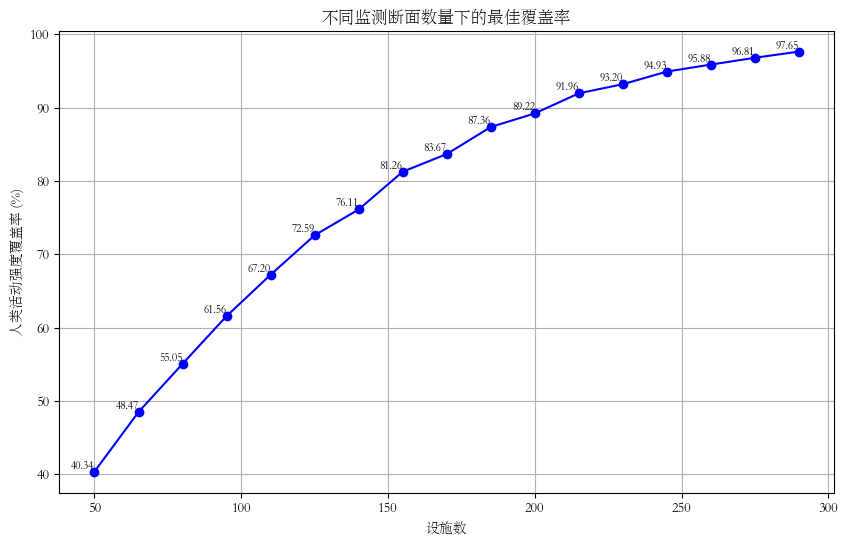

In [ ]:
import matplotlib.pyplot as plt

# 设置字体为中文字体
plt.rcParams['font.sans-serif'] = ['STSong']
plt.rcParams['axes.unicode_minus'] = False

# 绘制覆盖率与新增监测点数的关系图
x_values = list(coverage_results.keys())
y_values = [coverage_results[x] for x in x_values]

plt.plot(x_values, y_values, marker='o')
plt.xlabel('新增监测点数')
plt.ylabel('覆盖率')
plt.title('新增监测点数与覆盖率的关系')
plt.legend()
plt.grid(False)
plt.show()
